# Masterthesis
## Regression

#### Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import category_encoders as ce
from tensorflow.python.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV, KFold 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
import matplotlib.pyplot as plt
from scipy import stats

Using TensorFlow backend.


In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT']

In [3]:
df = pd.read_csv('resources/accident_data.csv', sep=";", na_values=na_values, index_col=False, dtype = {"STATE" : "str", "TYPE" : "str", "TYPEQ" : "str", "WEATHER" : "str", "VISIBLTY" : "str", "SPD_TOO_HIGH" : "str"})
df.shape[0]

70759

In [4]:
df=df.dropna(subset=['INFRASTRUCTURE_DMG', 'YEAR4', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'STATE', 'SPD_TOO_HIGH', 'ACCIDENT_TYPE', 'Jahreszeit'])

In [5]:
std_dev = 2
#df = df[(np.abs(stats.zscore(df[['LOCOMOTIVES1','LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2','LOADF2', 'EMPTYF2', 'INFRASTRUCTURE_DMG']])) < float(std_dev)).all(axis=1)]

In [6]:
pd.set_option('display.max_columns', 500)
#df.head(50)

In [7]:
df[df['TONS']==0].shape[0]

0

In [8]:
df[df['SPEED']==0].shape[0]

1159

In [9]:
df[df['INFRASTRUCTURE_DMG']==0].shape[0]

7

In [10]:
df.isnull().values.any()

True

In [11]:
#df.isnull().sum()

## Vorbereitungen

Festlegen der abhängigen Variablen X und der vorherzusagenden Variable y

In [12]:
#x_data = df[['YEAR4', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'STATE', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']]
y = df['INFRASTRUCTURE_DMG']

In [13]:
x_data = df[['TEMP', 'TYPEQ', 'TRKCLAS', 'ACCCAUSE_LVL1', 'ACCCAUSE_LVL2', 'ACCAUSE', 'YEAR4', 'STATE', 'MONTH', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']]

In [14]:
x_data.shape[0]

70715

In [15]:
print(x_data.isnull().sum())

TEMP              0
TYPEQ             0
TRKCLAS           0
ACCCAUSE_LVL1     0
ACCCAUSE_LVL2     0
ACCAUSE           0
YEAR4             0
STATE             0
MONTH             0
LOCOMOTIVES1      0
LOADF1            0
LOADP1            0
EMPTYF1           0
EMPTYP1           0
LOCOMOTIVES2      0
LOADF2            0
EMPTYF2           0
LOADP2            0
EMPTYP2           0
TONS              0
TEMP_CLUSTER      0
SPEED             0
ACCCAUSE_LVL1     0
TYPE              0
EQUIPMENT_TYPE    0
TYPTRK            0
VISIBLTY          0
WEATHER           0
SPD_TOO_HIGH      0
ACCTYPE           0
ACCIDENT_TYPE     0
Jahreszeit        0
dtype: int64


In [16]:
print(y.isnull().sum())

0


#### Aufteilen der Daten in Train und Test Datensatz

In [17]:
def prepare_inputs_One_Hot(x):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [18]:
def prepare_inputs_Ordinal(x):
    encoder = OrdinalEncoder()
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [19]:
def prepare_inputs_Binary(x, cats):
    encoder = ce.BinaryEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats])
    df_bin = encoder.transform(x[cats])
    return df_bin

In [20]:
def prepare_inputs_Target(x, Y, cats, smoothing):
    encoder = ce.TargetEncoder(cols=cats, return_df=True, min_samples_leaf = 5, smoothing=smoothing)
    encoder.fit(x[cats], Y)
    df_te = encoder.transform(x[cats], Y)
    return df_te

In [21]:
def prepare_inputs_Leave_One_Out(x, Y, cats):
    encoder = ce.LeaveOneOutEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats], Y)
    df_loo = encoder.transform(x[cats], Y)
    return df_loo

In [22]:
def prepare_inputs_HelmertEncoder(x, cats):
    encoder = ce.HelmertEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats])
    df_woe = encoder.transform(x[cats])
    return df_woe

## Features





In [23]:
#cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'TYPTRK', 'WEATHER', 'VISIBLTY', 'STATE', 'ACCCAUSE_LVL1', 'SPD_TOO_HIGH', 'ACCTYPE', 'TRKCLAS']

In [24]:
#con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

In [25]:
cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'STATE']

In [26]:
con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1' , 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

In [27]:
x_enc_cat = prepare_inputs_Ordinal(x_data[cat])

In [28]:
#x_enc_cat = prepare_inputs_One_Hot(x_data[cat])

In [29]:
#x_enc_cat = prepare_inputs_Binary(x_data, cat)

In [30]:
#x_enc_cat = prepare_inputs_Target(x_data, y, cat, 1.0)

In [31]:
#x_enc_cat = prepare_inputs_Target(x_data, y, cat, 10)

In [32]:
#x_enc_cat = prepare_inputs_Leave_One_Out(x_data, y, cat)

In [33]:
#x_enc_cat = prepare_inputs_HelmertEncoder(x_data, cat)

In [34]:
#cs = MinMaxScaler().fit(x_data[con])
cs = StandardScaler().fit(x_data[con])
x_enc_con = cs.transform(x_data[con])
#x_enc_con = x_data[con]

In [35]:
#cs_y = MinMaxScaler().fit(y.reshape(1, -1))
cs_y = StandardScaler().fit(y.values.reshape(-1, 1))
#y = cs_y.transform(y.values.reshape(-1, 1))

In [36]:
X_Data = np.hstack([x_enc_cat, x_enc_con])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, y, test_size=0.3, random_state=42)

In [38]:
n_features = X_train.shape[1]

## Sequential regression model

In [39]:
def create_model(learning_rate = 0.01, activation = 'relu'):
    seq_model = Sequential()
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    seq_model.add(Dense(32, activation = activation, input_shape=(n_features,)))
    seq_model.add(BatchNormalization())
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(64, activation = activation))
    seq_model.add(Dropout(0.5))
    #seq_model.add(Dense(128, activation = activation))
    #seq_model.add(Dropout(0.5))
    #seq_model.add(Dense(64, activation = activation))
    #seq_model.add(Dropout(0.5))
    #seq_model.add(Dense(32, activation = activation))
    #seq_model.add(Dropout(0.5))
    seq_model.add(Dense(1, activation = activation))
    seq_model.summary()
    seq_model.compile(optimizer=opt, loss='mse', metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'msle', 'mape'])
    return seq_model

In [40]:
model = KerasRegressor(build_fn = create_model)

In [41]:
params = {'activation': ["relu", "tanh", "sigmoid", "selu", "softmax"],'batch_size': [32, 64], 'epochs': [50, 100, 300, 1000],'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0001]}

In [42]:
random_search = RandomizedSearchCV(model, param_distributions = params,cv = KFold(10))

In [43]:
#random_search_results = random_search.fit(X_train, y_train)

In [44]:
#print("Best Score: ",random_search_results.best_score_,"and Best Params: ",random_search_results.best_params_)

### Regression Allgemein

In [45]:
epochs = 150

In [46]:
learning_rate = 0.01

In [47]:
activation = 'relu'

In [48]:
dropout = 0

In [49]:
metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape']

In [50]:
#opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate , nesterov=True)
opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)



## Sequential Regression with Keras

In [51]:
seq_model = Sequential()

seq_model.add(Dense(512, activation=activation, input_shape=(n_features,)))
seq_model.add(BatchNormalization())
seq_model.add(Dropout(dropout))
seq_model.add(Dense(256, activation=activation))
#seq_model.add(BatchNormalization())
#seq_model.add(Dense(128, activation=activation))
#seq_model.add(Dropout(dropout))
#seq_model.add(Dense(64, activation=activation))
#seq_model.add(Dropout(dropout))
#seq_model.add(Dense(32, activation=activation))
#seq_model.add(Dropout(dropout))
seq_model.add(Dense(1))
seq_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [52]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 143,361
Trainable params: 142,337
Non-trainable params: 1,024
_________________________________________________________________


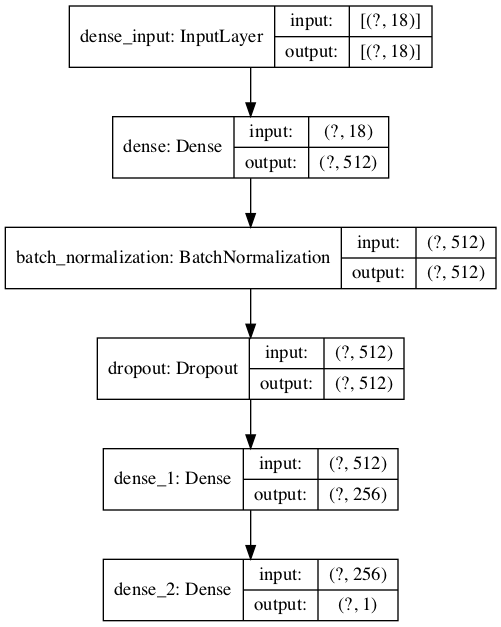

In [53]:
plot_model(seq_model, 'Images/Sequential Regression Model.png', show_shapes=True)

In [54]:
es = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=32)

Epoch 1/150
1547/1547 [==============================] - 4s 2ms/step - loss: 174464450560.0000 - mse: 174464450560.0000 - rmse: 417689.4062 - mae: 108245.2500 - mape: 548277.1250 - val_loss: 120805015552.0000 - val_mse: 120805015552.0000 - val_rmse: 347570.1562 - val_mae: 106732.8516 - val_mape: 380396.6250
Epoch 2/150
1547/1547 [==============================] - 3s 2ms/step - loss: 174461763584.0000 - mse: 174461763584.0000 - rmse: 417686.1875 - mae: 108233.7578 - mape: 1390720.6250 - val_loss: 120802025472.0000 - val_mse: 120802025472.0000 - val_rmse: 347565.8438 - val_mae: 106719.6719 - val_mape: 799884.9375
Epoch 3/150
1547/1547 [==============================] - 3s 2ms/step - loss: 174458257408.0000 - mse: 174458257408.0000 - rmse: 417682.0000 - mae: 108219.1016 - mape: 2557090.5000 - val_loss: 120798117888.0000 - val_mse: 120798117888.0000 - val_rmse: 347560.2500 - val_mae: 106702.2812 - val_mape: 1407991.1250
Epoch 4/150
1547/1547 [==============================] - 3s 2ms/step -

1547/1547 [==============================] - 3s 2ms/step - loss: 173830897664.0000 - mse: 173830897664.0000 - rmse: 416930.3125 - mae: 106267.3672 - mape: 119346752.0000 - val_loss: 120081981440.0000 - val_mse: 120081981440.0000 - val_rmse: 346528.4688 - val_mae: 104641.2734 - val_mape: 74812192.0000
Epoch 28/150
1547/1547 [==============================] - 3s 2ms/step - loss: 173765246976.0000 - mse: 173765246976.0000 - rmse: 416851.5938 - mae: 106104.9453 - mape: 124016776.0000 - val_loss: 120014577664.0000 - val_mse: 120014577664.0000 - val_rmse: 346431.1875 - val_mae: 104487.8594 - val_mape: 80144488.0000
Epoch 29/150
1547/1547 [==============================] - 3s 2ms/step - loss: 173689323520.0000 - mse: 173689323520.0000 - rmse: 416760.5000 - mae: 105933.6172 - mape: 135106448.0000 - val_loss: 119933444096.0000 - val_mse: 119933444096.0000 - val_rmse: 346314.0938 - val_mae: 104300.2188 - val_mape: 90660504.0000
Epoch 30/150
1547/1547 [==============================] - 3s 2ms/ste

1547/1547 [==============================] - 3s 2ms/step - loss: 168472494080.0000 - mse: 168472494080.0000 - rmse: 410454.0000 - mae: 98990.8047 - mape: 312474240.0000 - val_loss: 114059788288.0000 - val_mse: 114059788288.0000 - val_rmse: 337727.3750 - val_mae: 97285.8359 - val_mape: 530231040.0000
Epoch 54/150
1547/1547 [==============================] - 3s 2ms/step - loss: 168076705792.0000 - mse: 168076705792.0000 - rmse: 409971.5938 - mae: 98564.8906 - mape: 360874560.0000 - val_loss: 113565024256.0000 - val_mse: 113565024256.0000 - val_rmse: 336994.0938 - val_mae: 96864.5156 - val_mape: 566070464.0000
Epoch 55/150
1547/1547 [==============================] - 3s 2ms/step - loss: 167674658816.0000 - mse: 167674658816.0000 - rmse: 409480.9688 - mae: 98135.1328 - mape: 326060480.0000 - val_loss: 112882835456.0000 - val_mse: 112882835456.0000 - val_rmse: 335980.4062 - val_mae: 96158.3750 - val_mape: 622984256.0000
Epoch 56/150
1547/1547 [==============================] - 3s 2ms/step -

Epoch 79/150
1547/1547 [==============================] - 3s 2ms/step - loss: 155308998656.0000 - mse: 155308998656.0000 - rmse: 394092.6250 - mae: 88768.1016 - mape: 685867584.0000 - val_loss: 99207954432.0000 - val_mse: 99207954432.0000 - val_rmse: 314972.9375 - val_mae: 86064.0547 - val_mape: 1929908096.0000
Epoch 80/150
1547/1547 [==============================] - 3s 2ms/step - loss: 154751893504.0000 - mse: 154751893504.0000 - rmse: 393385.1875 - mae: 88659.5547 - mape: 983868544.0000 - val_loss: 98083553280.0000 - val_mse: 98083553280.0000 - val_rmse: 313182.9375 - val_mae: 85579.4922 - val_mape: 1996584832.0000
Epoch 81/150
1547/1547 [==============================] - 3s 2ms/step - loss: 154245922816.0000 - mse: 154245922816.0000 - rmse: 392741.5625 - mae: 88382.8359 - mape: 1053831616.0000 - val_loss: 98151489536.0000 - val_mse: 98151489536.0000 - val_rmse: 313291.3750 - val_mae: 85576.2969 - val_mape: 2049320704.0000
Epoch 82/150
1547/1547 [==============================] - 3s

1547/1547 [==============================] - 3s 2ms/step - loss: 142653308928.0000 - mse: 142653308928.0000 - rmse: 377694.7188 - mae: 86768.3828 - mape: 1564519680.0000 - val_loss: 85106081792.0000 - val_mse: 85106081792.0000 - val_rmse: 291729.4688 - val_mae: 82498.4297 - val_mape: 3336591616.0000
Epoch 106/150
1547/1547 [==============================] - 3s 2ms/step - loss: 142241480704.0000 - mse: 142241480704.0000 - rmse: 377149.1562 - mae: 86837.5000 - mape: 1847415040.0000 - val_loss: 84945944576.0000 - val_mse: 84945944576.0000 - val_rmse: 291454.8750 - val_mae: 82481.1641 - val_mape: 3347450368.0000
Epoch 107/150
1547/1547 [==============================] - 3s 2ms/step - loss: 142027145216.0000 - mse: 142027145216.0000 - rmse: 376864.8750 - mae: 86913.9688 - mape: 1891410688.0000 - val_loss: 84520722432.0000 - val_mse: 84520722432.0000 - val_rmse: 290724.4688 - val_mae: 82670.5859 - val_mape: 3448509184.0000
Epoch 108/150
1547/1547 [==============================] - 3s 2ms/ste

1223/1547 [======================>.......] - ETA: 0s - loss: 147105529856.0000 - mse: 147105529856.0000 - rmse: 383543.3750 - mae: 89883.4453 - mape: 536858528.0000

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [ ]:
error = seq_model.evaluate(X_test, y_test)

In [ ]:
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f, MAPE: %.3f' % 
      (error[1], error[2], error[3], error[4]))

In [ ]:
predictions= seq_model.predict(X_test)
plt.plot(y_test, predictions, 'o')
plt.xlabel('Actual values (test data)')
plt.ylabel('predicted values (test data)')

In [ ]:
r2_seq = r2_score(y_test, predictions)
r2_seq

In [ ]:
adj_r2_seq = 1-(1-r2_seq)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))

In [ ]:
print(('%.6f \t %.6f \t %.0f  \t %.0f \t %.0f  \t %.0f ' % 
      (r2_seq, adj_r2_seq, error[2], error[1], error[3], error[4])).replace('.', ','))

In [ ]:
train_predictions = seq_model.predict(X_train)
plt.plot(y_train, train_predictions, 'o')
plt.xlabel('Actual values (train data)')
plt.ylabel('predicted values (train data)')

In [ ]:
predictions = predictions.flatten()

In [ ]:
train_predictions = train_predictions.flatten()

In [ ]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
plt.scatter(train_predictions, train_predictions - y_train, c='b', s=40, alpha=0.5, label='Train Data')
plt.scatter(predictions, predictions - y_test, c='g', s=40, label='Test Data')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot of DNN Regression')
plt.ylabel('Residuals')
plt.xlabel('Accident Damage')
plt.legend()
plt.show()

## Functional API Regression Model with Keras

In [ ]:
x_in = Input(shape=(n_features,))
dense = Dense(1024, activation=activation)
x = dense(x_in)
x = Dropout(dropout)(x)
x = Dense(512, activation=activation)(x)
#x = Dense(256, activation=activation)(x)
#x = Dropout(dropout)(x)
#x = Dense(128, activation=activation)(x)
#x = Dropout(dropout)(x)
#x = Dense(64, activation=activation)(x)
#x = Dropout(dropout)(x)
x_out = Dense(1)(x)
func_model = Model(inputs=x_in, outputs=x_out)

In [ ]:
func_model.summary()

In [ ]:
plot_model(func_model, 'Images/Functional API Regression Model.png', show_shapes=True)

In [ ]:
func_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=32)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(func_history.history['loss'], label='train')
plt.plot(func_history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [ ]:
mse = func_model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f, MAPE: %.3f' % 
      (mse[1], mse[2], mse[3], mse[4]))

In [ ]:
func_predictions=func_model.predict(X_test)
plt.plot(y_test, func_predictions, 'o')
plt.xlabel('Actual values (test data)')
plt.ylabel('predicted values (test data)')

In [ ]:
r2_func = r2_score(y_test, func_predictions)
r2_func

In [ ]:
adj_r2_func = 1-(1-r2_func)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
adj_r2_func

In [ ]:
print(('%.6f \t %.6f \t %.0f  \t %.0f \t %.0f  \t %.0f ' % 
      (r2_func, adj_r2_func, mse[2], mse[1], mse[3], mse[4])).replace('.', ','))

In [ ]:
func_train_predictions=func_model.predict(X_train)
plt.plot(y_train, func_train_predictions, 'o')
plt.xlabel('Actual values (train data)')
plt.ylabel('predicted values (train data)')

In [ ]:
func_predictions = func_predictions.flatten()

In [ ]:
func_train_predictions = func_train_predictions.flatten()

In [ ]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': func_predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
plt.scatter(func_train_predictions, func_train_predictions - y_train, c='b', s=40, alpha=0.5, label='Train Data')
plt.scatter(func_predictions, func_predictions - y_test, c='g', s=40, label='Test Data')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot of DNN Regression')
plt.ylabel('Residuals')
plt.xlabel('Accident Damage')
plt.legend()
plt.show()

## Polynomial Regression with Scikit-Learn
* Polynomial Regression
* Polynomial Regression with Lasso => Lasso Regression schrumpft Koeffizienten um absoluten Wert -> ausselektieren.
* Polynomial Regression with Ridge (Ridge Regression or Tikhonov regularization) => Ridge Regression schrumpft Koeffizienten um relativen Wert.

In [ ]:
def poly_regression(X_train, X_test, Y_train, Y_test, reg):
    reg.fit(X_train, Y_train)
    y_pred = reg.predict(X_test)
    coef = reg.coef_
    intercept = reg.intercept_
    r2 = r2_score(Y_test, y_pred)
    MSA = mean_absolute_error(Y_test, y_pred) 
    MSE = mean_squared_error(Y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(Y_test, y_pred)
    
    return [r2, MSA, MSE, RMSE, MSLE]

In [ ]:
def create_polynomial_regression_model(degree, reg):  
    poly_feat = PolynomialFeatures(degree=degree)
    X_train_poly = poly_feat.fit_transform(X_train)
    poly = reg[1].fit(X_train_poly, y_train)
    y_train_pred = poly.predict(X_train_poly)
    y_pred = poly.predict(poly_feat.fit_transform(X_test))
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
    MSA = mean_absolute_error(y_test, y_pred) 
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    #MSLE = mean_squared_log_error(y_test, y_pred)
    
    #print("The model performance with %s and a degree of %s" % (reg[0], degree))
    #print("R2 score of test set is %s" % (r2))
    #print("RMSE score of test set is %s" % (RMSE))
    #print("MSE score of test set is %s" % (MSE))
    #print("-------------------------------------------")
    #print(("%s \t %s \t %.6f \t %.0f \t %.4f" % (reg[0], degree, r2, RMSE, MSE)).replace('.', ','))
    print(("%.6f \t %.6f \t %.0f \t %.0f \t %.0f" % (r2, adj_r2, RMSE, MSE, MAE)).replace('.', ','))
    return [r2, adj_r2, MSA, MSE, RMSE, reg[1].coef_]

In [ ]:
#poly = PolynomialFeatures(n_features)

In [ ]:
degrees = [10, 15, 20]
poly_models = [["Lasso", Lasso()], ["ElasticNet", ElasticNet()]]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#for mod in poly_models:
#    for deg in degrees:
#        poly_reg = create_polynomial_regression_model(deg, mod)

In [ ]:
#poly_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, LinearRegression())

In [ ]:
#poly_lasso_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, Lasso())

In [ ]:
#poly_ridge_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, Ridge())

## Regression Results

In [ ]:
"""regressionresults = [
                                [
                                    r2_func ,mse[1], mse[2], mse[4], mse[3], mse[5]
                                ],
                                [
                                    r2_seq ,error[1], error[2], error[4], error[3], error[5]
                                ],
                                [
                                    r2, polyerror[1], polyerror[2], polyerror[4], polyerror[3], polyerror[5]
                                ],
                                [
                                    poly_reg[0],  poly_reg[2], poly_reg[3], poly_reg[4], poly_reg[1], np.NaN
                                ],
                                [
                                    poly_lasso_reg[0],  poly_lasso_reg[2], poly_lasso_reg[3], poly_lasso_reg[4], poly_lasso_reg[1], np.NaN
                                ],
                                [
                                    poly_ridge_reg[0],  poly_ridge_reg[2], poly_ridge_reg[3], poly_ridge_reg[4], poly_ridge_reg[1], np.NaN
                                ]
                            ]
reg_results = pd.DataFrame(regressionresults,columns=["R2", "MSE", "RMSE","MSLE", "MAE", "MAPE"], index=["Functional Neural Network Regression (Keras)", "Sequential Neural Network Regression (Keras)", "Polynomial Regression (Keras)", "Polynomial Regression (Scikit-Learn)", "Polynomial Regression with Lasso (Scikit-Learn)", "Polynomial Regression with Ridge (Scikit-Learn)"]).style.format("{:,.1f}")
"""

In [ ]:
#reg_results